First of all, I am very keen on trying new methods. This is why I tried an Ensemble Deep Learning method in this project. I impressed an article named "HCF: A Hybrid CNN Framework for Behavior Detection of Distracted Drivers" in this project [1]. In this technique, first I used 2 pretrained models (Xception, and DenseNet201). Then saved models and weights for using in the ensemble model. At this stage, I combined the 2 models with the GlobalAveragePooling2D layer outputs (as in the article). In conclusion, there is a lightly improvement in respect of the model's accuracy and F1 score.

<i><b><span style="color:#e74c3c;"> Note: Of course, there are other models better than my model in respect of the classification metrics, but I tried to a basic implementation of a paper. </span> </b></i>

## Xception + DenseNet201 --> The Ensemble Model

<i> Figure : the proposed framework in the paper [1]</i>

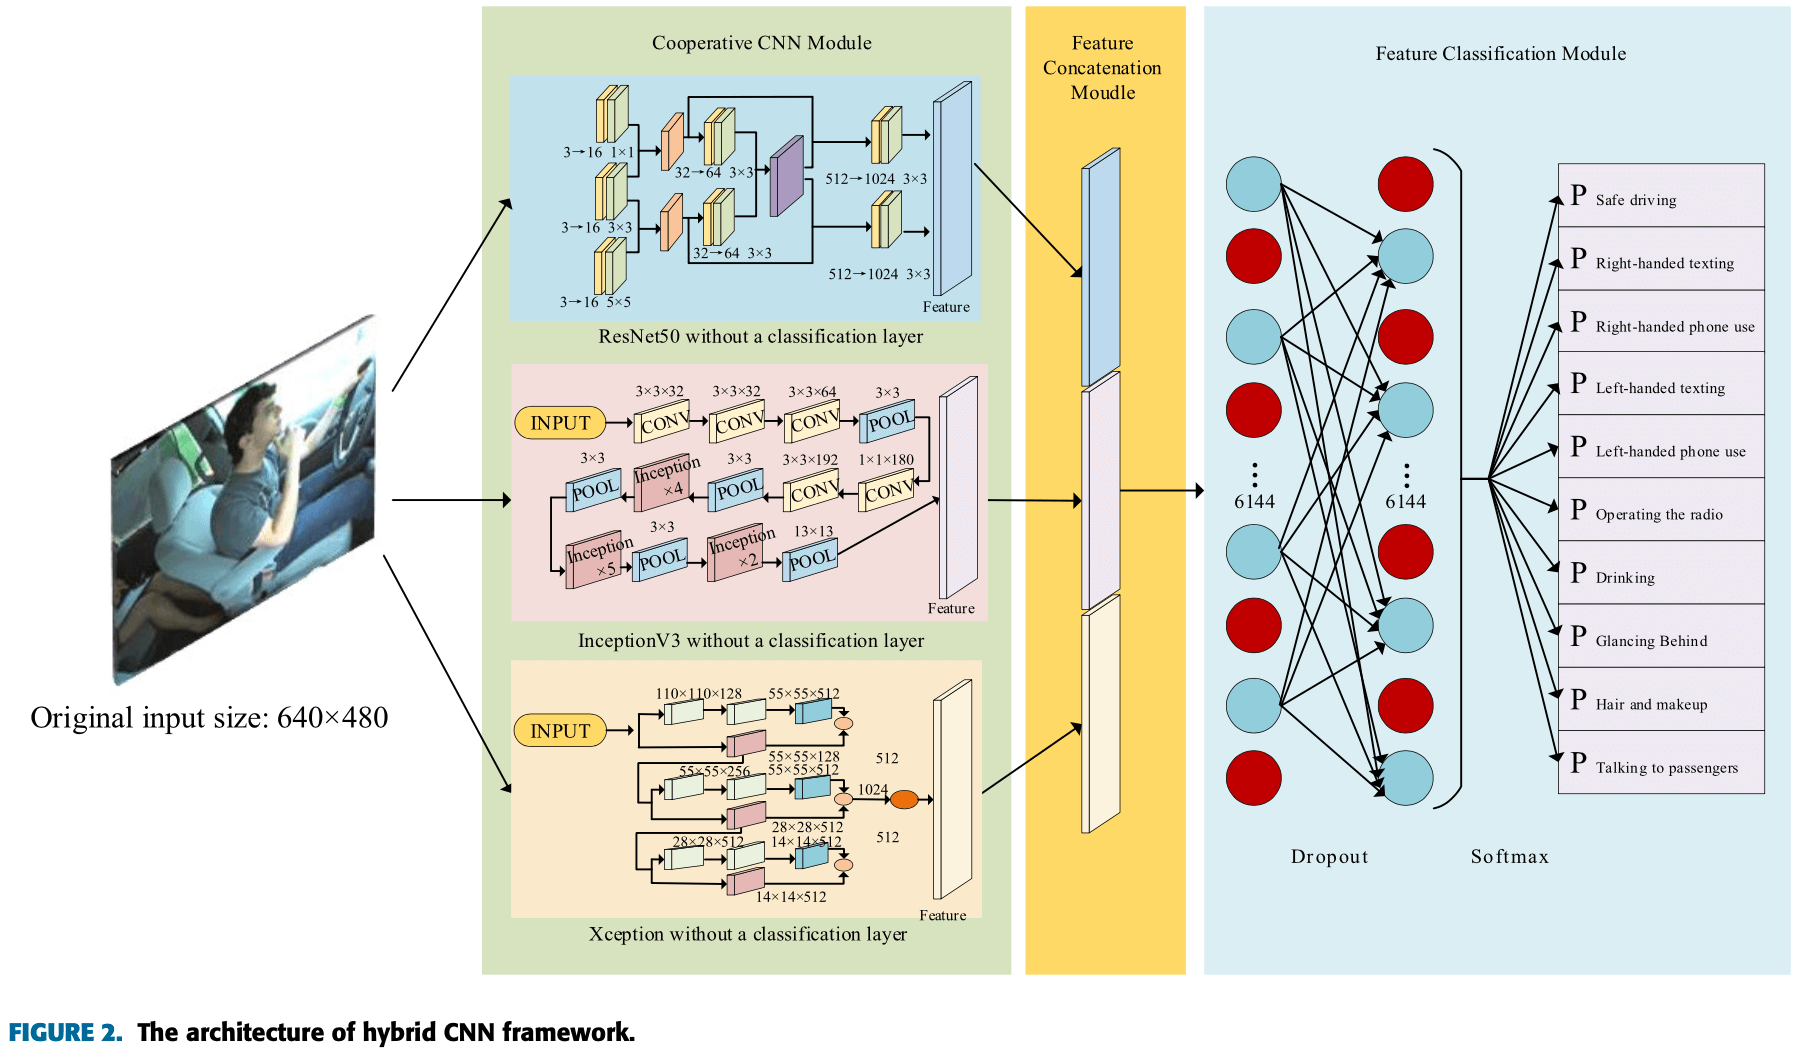


I have used the following methods.

* The project took place using <b>Google TPU</b>,
* Used <b>tf.data</b> for input pipeline,
* I split the full data into train, validation and test sets,
* Used <b>tf.data</b> for input pipeline,


## My Another Projects
* [Diamond Detect w/Meta-Learning (ViT,CatBoost,SHAP)](https://www.kaggle.com/code/banddaniel/diamond-detect-w-meta-learning-vit-catboost-shap)
* [Bladder Tissue Classification w/ViT (F1 Scr: 0.82)](https://www.kaggle.com/code/banddaniel/bladder-tissue-classification-w-vit-f1-scr-0-82)
* [(76 GB) 160 Polish Bird Sounds Classification](https://www.kaggle.com/code/banddaniel/76-gb-160-polish-bird-sounds-classification)
* [Segment Medical Instrument, w/Custom DeepLabv3+(Dice: 0.86)](https://www.kaggle.com/code/banddaniel/segment-medical-instrument-deeplabv3-dice-0-86)
* [Jellyfish Detect (10CV Custom ConvMixer) (F1:0.87)](https://www.kaggle.com/code/banddaniel/jellyfish-detect-10cv-custom-convmixer-f1-0-87)


## References
1. Huang, C., Wang, X., Cao, J., Wang, S., & Zhang, Y. (2020). HCF: A Hybrid CNN Framework for Behavior Detection of Distracted Drivers. In IEEE Access (Vol. 8, pp. 109335–109349). Institute of Electrical and Electronics Engineers (IEEE). https://doi.org/10.1109/access.2020.3001159

In [1]:
# Importing dependencies

import os
import logging
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Activation, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception, DenseNet201


IMG_SIZE = 224, 224
BATCH_SIZE = 64
SEED = 6
AUTO = tf.data.AUTOTUNE
tf.random.set_seed(SEED)

# <span style="color:#e74c3c;"> Reading </span> Data

In [2]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


def create_full_img_class_df(full_path):
    full_images_path = create_images_list(full_path)
    
    data = pd.DataFrame()
    img_rows = []
    label_rows = []
    
    for i in range(len(full_images_path)):
        x = create_images_list(full_images_path[i])
        img_rows.extend(x)
        label_rows.extend([i]*len(x))
    
    data['img'] = img_rows
    data['label'] = label_rows
    
    return data


# look-up table
classes = {0: 'african_elephant', 1: 'alpaca', 2: 'american_bison', 3: 'anteater', 4: 'arctic_fox', 5: 'armadillo', 6: 'baboon', 7: 'badger', 8: 'blue_whale', 9: 'brown_bear', 10: 'camel', 11: 'dolphin', 12: 'giraffe', 13: 'groundhog', 14: 'highland_cattle', 15: 'horse', 16: 'jackal', 17: 'kangaroo', 18: 'koala', 19: 'manatee', 20: 'mongoose', 21: 'mountain_goat', 22: 'opossum', 23: 'orangutan', 24: 'otter', 25: 'polar_bear', 26: 'porcupine', 27: 'red_panda', 28: 'rhinoceros', 29: 'sea_lion', 30: 'seal', 31: 'snow_leopard', 32: 'squirrel', 33: 'sugar_glider', 34: 'tapir', 35: 'vampire_bat', 36: 'vicuna', 37: 'walrus', 38: 'warthog', 39: 'water_buffalo', 40: 'weasel', 41: 'wildebeest', 42: 'wombat', 43: 'yak', 44: 'zebra'}

full_data = create_full_img_class_df('/kaggle/input/mammals-image-classification-dataset-45-animals/mammals')

# <span style="color:#e74c3c;"> Creating </span> Train, Validation, Test Sets

In [3]:
y = full_data.pop('label')
X = full_data

X_data, X_test, y_data, y_test =  train_test_split(X, y, test_size = 0.1, stratify = y, random_state=SEED, shuffle=True)
X_train, X_val, y_train, y_val =  train_test_split(X_data, y_data, test_size = 0.09, stratify = y_data, random_state=SEED, shuffle=True)

print("train shape -> ", X_train.shape[0])
print("val shape -> ", X_val.shape[0])
print("test shape -> ", X_test.shape[0])

train shape ->  11261
val shape ->  1114
test shape ->  1376


In [4]:
# Connecting TPU 
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

stg = tf.distribute.experimental.TPUStrategy(resolver)

clear_output()

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [5]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

# Data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image, seed = SEED)
    img = tf.image.random_flip_up_down(img, seed = SEED)
    img = tf.image.random_brightness(img, 0.1, seed = SEED)
    img = tf.image.random_contrast(img, 0.2, 0.4, seed = SEED)
    img = tf.image.random_saturation(img, 2, 4, seed = SEED)
    
    return img, label

In [6]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_train['img'], y_train))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .map(augmentation, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*15)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((X_val['img'], y_val))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))
    
    
test_loader = tf.data.Dataset.from_tensor_slices((X_test['img'], y_test))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

# <span style="color:#e74c3c;"> Model 1 </span> Xception

In [7]:
with stg.scope():
    xception = Xception(include_top = False, weights = 'imagenet')
    

    inp = Input(shape = (*IMG_SIZE, 3))
    X = xception(inp)
    X = GlobalAveragePooling2D(name = 'the_last_average_pooling_layer')(X)

    X = Dense(256, activation = 'elu')(X)
    X = Dense(64, activation = 'elu')(X)

    out = Dense(45, activation = 'softmax')(X)

    xception_model = Model(inputs = inp, outputs = out)
    xception_model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
                           loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics = ['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top_10_cat_acc")] )

2023-11-15 10:11:49.996089: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:11:49.996166: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


83683744/83683744 [==============================] - 0s 0us/step


2023-11-15 10:11:57.600698: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:11:57.601576: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:11:57.602132: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:11:57.602947: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:11:57.603659: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:11:57.604336: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:11:57.604973: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [8]:
hist1 = xception_model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 10, validation_data = valid_dataset)
xception_model.save('xception_model.h5')

Epoch 1/10


2023-11-15 10:12:26.700781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2023-11-15 10:12:29.360407: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:12:29.363960: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:12:29.364108: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:12:29.364731: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:12:29.365286: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:12:29.365773: E ./tensorflow/compiler/xla/stream_executor/s

  1/176 [..............................] - ETA: 2:44:04 - loss: 3.7768 - acc: 0.0156 - top_10_cat_acc: 0.3125

2023-11-15 10:13:03.844330: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:13:03.844496: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:13:03.844575: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:13:03.844649: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:13:03.844789: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:13:03.844880: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:13:03.844972: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  4/176 [..............................] - ETA: 16s - loss: 3.7827 - acc: 0.0664 - top_10_cat_acc: 0.2969

2023-11-15 10:13:04.083085: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 10/176 [>.............................] - ETA: 15s - loss: 3.7199 - acc: 0.0719 - top_10_cat_acc: 0.3688

2023-11-15 10:13:04.627285: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 61/176 [=========>....................] - ETA: 9s - loss: 2.9451 - acc: 0.3299 - top_10_cat_acc: 0.6926

2023-11-15 10:13:08.889653: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


176/176 [==============================] - ETA: 0s - loss: 1.8850 - acc: 0.5683 - top_10_cat_acc: 0.8560

2023-11-15 10:13:27.810406: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


176/176 [==============================] - 86s 170ms/step - loss: 1.8850 - acc: 0.5683 - top_10_cat_acc: 0.8560 - val_loss: 0.3789 - val_acc: 0.9013 - val_top_10_cat_acc: 0.9901
Epoch 2/10
  2/176 [..............................] - ETA: 14s - loss: 0.7619 - acc: 0.8047 - top_10_cat_acc: 0.9844 

2023-11-15 10:13:34.425150: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


176/176 [==============================] - 16s 88ms/step - loss: 0.6278 - acc: 0.8418 - top_10_cat_acc: 0.9810 - val_loss: 0.3193 - val_acc: 0.9174 - val_top_10_cat_acc: 0.9928
Epoch 3/10
 38/176 [=====>........................] - ETA: 10s - loss: 0.4252 - acc: 0.8923 - top_10_cat_acc: 0.9893

2023-11-15 10:13:53.711426: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


176/176 [==============================] - 16s 86ms/step - loss: 0.3510 - acc: 0.9092 - top_10_cat_acc: 0.9918 - val_loss: 0.3181 - val_acc: 0.9111 - val_top_10_cat_acc: 0.9937
Epoch 4/10
176/176 [==============================] - 16s 86ms/step - loss: 0.2145 - acc: 0.9454 - top_10_cat_acc: 0.9963 - val_loss: 0.3286 - val_acc: 0.9165 - val_top_10_cat_acc: 0.9928
Epoch 5/10
176/176 [==============================] - 16s 87ms/step - loss: 0.1629 - acc: 0.9592 - top_10_cat_acc: 0.9977 - val_loss: 0.3257 - val_acc: 0.9129 - val_top_10_cat_acc: 0.9964
Epoch 6/10
  2/176 [..............................] - ETA: 12s - loss: 0.3026 - acc: 0.9219 - top_10_cat_acc: 0.9922 

2023-11-15 10:14:39.354122: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


176/176 [==============================] - 16s 86ms/step - loss: 0.1312 - acc: 0.9664 - top_10_cat_acc: 0.9979 - val_loss: 0.3153 - val_acc: 0.9183 - val_top_10_cat_acc: 0.9955
Epoch 7/10
176/176 [==============================] - 16s 87ms/step - loss: 0.0976 - acc: 0.9742 - top_10_cat_acc: 0.9993 - val_loss: 0.3345 - val_acc: 0.9102 - val_top_10_cat_acc: 0.9919
Epoch 8/10
176/176 [==============================] - 16s 91ms/step - loss: 0.0878 - acc: 0.9774 - top_10_cat_acc: 0.9993 - val_loss: 0.3554 - val_acc: 0.9084 - val_top_10_cat_acc: 0.9937
Epoch 9/10
176/176 [==============================] - 16s 87ms/step - loss: 0.0805 - acc: 0.9794 - top_10_cat_acc: 0.9992 - val_loss: 0.3349 - val_acc: 0.9156 - val_top_10_cat_acc: 0.9928
Epoch 10/10
176/176 [==============================] - 16s 87ms/step - loss: 0.0696 - acc: 0.9823 - top_10_cat_acc: 0.9995 - val_loss: 0.3531 - val_acc: 0.9165 - val_top_10_cat_acc: 0.9946


# <span style="color:#e74c3c;"> Model 1 Test  </span> Results, Predictions

In [9]:
with stg.scope():
    model1_eval = xception_model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(model1_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(model1_eval[1]*100))
    print('Test 10 Classes Accuracy: {0:.3f} %'.format(model1_eval[2]*100))

22/22 [==============================] - 2s 30ms/step - loss: 0.3783 - acc: 0.9193 - top_10_cat_acc: 0.9906
Test Loss: 0.378
Test Accuracy: 91.933 %
Test 10 Classes Accuracy: 99.055 %


In [10]:
# Predictions

with stg.scope():
    test_take =  test_dataset.take(-1)
    test_take_ = list(test_take)
    pred1 = xception_model.predict(test_take)
    pred1 = np.argmax(pred1, axis = 1)
    
    
# Predictions and scores
clf1= classification_report(y_test, pred1, target_names = list(classes.values()),  output_dict = True)
clf1_ = classification_report(y_test, pred1, target_names = list(classes.values()))

f1 = f1_score(y_test, pred1, average = 'weighted')
acc = accuracy_score(y_test, pred1)

print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))
print('--'*30)
print(clf1_)

2023-11-15 10:16:05.564489: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


22/22 [==============================] - 16s 312ms/step
Weighted F1 Score : 0.919
Accuracy Score : 91.933 %
------------------------------------------------------------
                  precision    recall  f1-score   support

african_elephant       0.97      1.00      0.99        35
          alpaca       0.86      0.91      0.88        33
  american_bison       1.00      0.97      0.99        34
        anteater       0.88      0.93      0.90        30
      arctic_fox       0.91      0.97      0.94        32
       armadillo       1.00      1.00      1.00        33
          baboon       0.97      0.88      0.92        33
          badger       0.97      0.90      0.93        31
      blue_whale       0.88      0.96      0.92        24
      brown_bear       0.94      0.97      0.95        30
           camel       0.96      0.92      0.94        25
         dolphin       0.88      0.90      0.89        31
         giraffe       0.94      1.00      0.97        31
       groundhog  

# <span style="color:#e74c3c;"> Model 2 </span> DenseNet201

In [11]:
with stg.scope():
    densenet = DenseNet201(include_top = False, weights = 'imagenet')

    inp = Input(shape = (*IMG_SIZE, 3))
    X = densenet(inp)
    X = GlobalAveragePooling2D(name = 'the_last_average_pooling_layer')(X)

    X = Dense(256, activation = 'elu')(X)

    out = Dense(45, activation = 'softmax')(X)

    densenet_model = Model(inputs = inp, outputs = out)
    densenet_model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
                           loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics = ['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top_10_cat_acc")] )

74836368/74836368 [==============================] - 0s 0us/step


In [12]:
hist2 = densenet_model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 10, validation_data = valid_dataset)
densenet_model.save('densenet_model.h5')

Epoch 1/10


2023-11-15 10:18:37.744659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.


176/176 [==============================] - ETA: 0s - loss: 1.5415 - acc: 0.6274 - top_10_cat_acc: 0.8965

2023-11-15 10:20:58.772938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


176/176 [==============================] - 251s 444ms/step - loss: 1.5415 - acc: 0.6274 - top_10_cat_acc: 0.8965 - val_loss: 0.4343 - val_acc: 0.8869 - val_top_10_cat_acc: 0.9910
Epoch 2/10
176/176 [==============================] - 38s 215ms/step - loss: 0.4743 - acc: 0.8786 - top_10_cat_acc: 0.9904 - val_loss: 0.2659 - val_acc: 0.9309 - val_top_10_cat_acc: 0.9973
Epoch 3/10
176/176 [==============================] - 39s 221ms/step - loss: 0.2813 - acc: 0.9301 - top_10_cat_acc: 0.9971 - val_loss: 0.2901 - val_acc: 0.9282 - val_top_10_cat_acc: 0.9955
Epoch 4/10
176/176 [==============================] - 39s 219ms/step - loss: 0.1808 - acc: 0.9557 - top_10_cat_acc: 0.9977 - val_loss: 0.2861 - val_acc: 0.9282 - val_top_10_cat_acc: 0.9937
Epoch 5/10
176/176 [==============================] - 39s 222ms/step - loss: 0.1292 - acc: 0.9685 - top_10_cat_acc: 0.9991 - val_loss: 0.2790 - val_acc: 0.9237 - val_top_10_cat_acc: 0.9937
Epoch 6/10
176/176 [==============================] - 38s 217ms/s

# <span style="color:#e74c3c;"> Model 2 Test  </span> Results, Predictions

In [13]:
with stg.scope():
    model2_eval = densenet_model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(model2_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(model2_eval[1]*100))
    print('Test 10 Classes Accuracy: {0:.3f} %'.format(model2_eval[2]*100))

22/22 [==============================] - 2s 58ms/step - loss: 0.3985 - acc: 0.8910 - top_10_cat_acc: 0.9935
Test Loss: 0.399
Test Accuracy: 89.099 %
Test 10 Classes Accuracy: 99.346 %


In [14]:
# Predictions

with stg.scope():
    test_take =  test_dataset.take(-1)
    test_take_ = list(test_take)
    pred2 = densenet_model.predict(test_take)
    pred2 = np.argmax(pred2, axis = 1)
    
    
# Predictions and scores
clf2 = classification_report(y_test, pred2, target_names = list(classes.values()),  output_dict = True)
clf2_ = classification_report(y_test, pred2, target_names = list(classes.values()))

f1 = f1_score(y_test, pred2, average = 'weighted')
acc = accuracy_score(y_test, pred2)

print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))
print('--'*30)
print(clf2_)

2023-11-15 10:27:44.050919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


22/22 [==============================] - 42s 941ms/step
Weighted F1 Score : 0.895
Accuracy Score : 89.099 %
------------------------------------------------------------
                  precision    recall  f1-score   support

african_elephant       0.97      0.91      0.94        35
          alpaca       0.91      0.97      0.94        33
  american_bison       0.97      0.94      0.96        34
        anteater       0.82      0.90      0.86        30
      arctic_fox       0.96      0.84      0.90        32
       armadillo       0.97      1.00      0.99        33
          baboon       0.94      0.94      0.94        33
          badger       0.90      0.87      0.89        31
      blue_whale       0.92      1.00      0.96        24
      brown_bear       0.96      0.83      0.89        30
           camel       0.92      0.88      0.90        25
         dolphin       0.96      0.87      0.92        31
         giraffe       0.97      0.97      0.97        31
       groundhog  

# <span style="color:#e74c3c;"> Final Emsemble</span> Model

In [15]:
with stg.scope():
    model1_ = tf.keras.models.load_model('/kaggle/working/xception_model.h5', compile=False)
    model2_ = tf.keras.models.load_model('/kaggle/working/densenet_model.h5', compile=False)

    model1 = Model(inputs=model1_.input, outputs=model1_.get_layer('the_last_average_pooling_layer').output)
    model2 = Model(inputs=model2_.input, outputs=model2_.get_layer('the_last_average_pooling_layer').output)

In [16]:
with stg.scope():
    
    models = [model1, model2]
    inp = Input(shape=(*IMG_SIZE, 3))

    X = [model(inp) for model in models]
    X = Concatenate()([X[0],X[1]]) 

    X = Dense(512, activation = 'elu')(X)
    X = Dense(128, activation = 'elu')(X)
    X = Dense(64, activation = 'elu')(X)

    out = Dense(45, activation = 'softmax')(X)
    
    ensemble_model = Model(inputs=inp, outputs=out)
    
    for layer in ensemble_model.layers[:4]:
        layer.trainable = False
    for layer in ensemble_model.layers[4:]:
        layer.trainable = True
        
    ensemble_model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
                           loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=10, name="top_10_cat_acc")] )

In [17]:
ensemble_hist = ensemble_model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 10, validation_data = valid_dataset)

Epoch 1/10


2023-11-15 10:29:35.620528: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.


176/176 [==============================] - 104s 348ms/step - loss: 0.5443 - acc: 0.9293 - top_10_cat_acc: 0.9730 - val_loss: 0.3263 - val_acc: 0.9273 - val_top_10_cat_acc: 0.9883
Epoch 2/10
176/176 [==============================] - 15s 84ms/step - loss: 0.0326 - acc: 0.9971 - top_10_cat_acc: 0.9999 - val_loss: 0.2808 - val_acc: 0.9318 - val_top_10_cat_acc: 0.9901
Epoch 3/10
176/176 [==============================] - 15s 85ms/step - loss: 0.0168 - acc: 0.9976 - top_10_cat_acc: 1.0000 - val_loss: 0.2803 - val_acc: 0.9264 - val_top_10_cat_acc: 0.9910
Epoch 4/10
176/176 [==============================] - 15s 84ms/step - loss: 0.0127 - acc: 0.9980 - top_10_cat_acc: 0.9999 - val_loss: 0.2781 - val_acc: 0.9228 - val_top_10_cat_acc: 0.9892
Epoch 5/10
176/176 [==============================] - 15s 84ms/step - loss: 0.0117 - acc: 0.9975 - top_10_cat_acc: 1.0000 - val_loss: 0.2772 - val_acc: 0.9255 - val_top_10_cat_acc: 0.9928
Epoch 6/10
176/176 [==============================] - 15s 84ms/step -

# <span style="color:#e74c3c;"> Final Model Test  </span> Results, Predictions

In [18]:
with stg.scope():
    final_model_eval = ensemble_model.evaluate(test_dataset)
    print('Test Loss: {0:.3f}'.format(final_model_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(final_model_eval[1]*100))
    print('Test 10 Classes Accuracy: {0:.3f} %'.format(final_model_eval[2]*100))

22/22 [==============================] - 2s 68ms/step - loss: 0.3274 - acc: 0.9172 - top_10_cat_acc: 0.9913
Test Loss: 0.327
Test Accuracy: 91.715 %
Test 10 Classes Accuracy: 99.128 %


In [19]:
# Predictions

with stg.scope():
    test_take =  test_dataset.take(-1)
    test_take_ = list(test_take)
    final_pred = ensemble_model.predict(test_take)
    final_pred = np.argmax(final_pred, axis = 1)
    
    
# Predictions and scores
clf_final = classification_report(y_test, final_pred, target_names = list(classes.values()),  output_dict = True)
clf_final_ = classification_report(y_test, final_pred, target_names = list(classes.values()))

f1 = f1_score(y_test, final_pred, average = 'weighted')
acc = accuracy_score(y_test, final_pred)

print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))
print('--'*30)
print(clf_final_)

2023-11-15 10:33:30.146095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


22/22 [==============================] - 49s 1s/step
Weighted F1 Score : 0.919
Accuracy Score : 91.715 %
------------------------------------------------------------
                  precision    recall  f1-score   support

african_elephant       1.00      1.00      1.00        35
          alpaca       0.84      0.94      0.89        33
  american_bison       1.00      0.91      0.95        34
        anteater       0.88      0.97      0.92        30
      arctic_fox       0.91      0.97      0.94        32
       armadillo       0.97      1.00      0.99        33
          baboon       0.97      0.91      0.94        33
          badger       0.93      0.90      0.92        31
      blue_whale       0.96      0.92      0.94        24
      brown_bear       1.00      0.93      0.97        30
           camel       1.00      0.88      0.94        25
         dolphin       0.93      0.87      0.90        31
         giraffe       1.00      1.00      1.00        31
       groundhog     

# <span style="color:#e74c3c;"> 3 Models </span> Classification Report

In [20]:
# 1.model
model1_precisions = []
model1_recalls = []
model1_f1scores = []

for i in range(len(list(classes.values()))):
    model1_precisions.append(clf1[list(classes.values())[i]]['precision'])
    model1_recalls.append(clf1[list(classes.values())[i]]['recall'])
    model1_f1scores.append(clf1[list(classes.values())[i]]['f1-score'])
    
    
# 2.model
model2_precisions = []
model2_recalls = []
model2_f1scores = []

for i in range(len(list(classes.values()))):
    model2_precisions.append(clf2[list(classes.values())[i]]['precision'])
    model2_recalls.append(clf2[list(classes.values())[i]]['recall'])
    model2_f1scores.append(clf2[list(classes.values())[i]]['f1-score'])
    

# Ensemble model 
model3_precisions = []
model3_recalls = []
model3_f1scores = []

for i in range(len(list(classes.values()))):
    model3_precisions.append(clf_final[list(classes.values())[i]]['precision'])
    model3_recalls.append(clf_final[list(classes.values())[i]]['recall'])
    model3_f1scores.append(clf_final[list(classes.values())[i]]['f1-score'])

In [21]:
# Precision values of models
precision_report = pd.DataFrame({'class_name': list(classes.values()),
                         'Xception' : model1_precisions,
                         'DenseNet201' : model2_precisions,
                         'Ensemble Model' : model3_precisions,})
precision_report.set_index('class_name', drop = True, inplace = True)

precision_report.style.highlight_max(color = '#1AB000', axis = 1)

,Xception,DenseNet201,Ensemble Model
class_name,,,
african_elephant,0.972222,0.969697,1.000000
alpaca,0.857143,0.914286,0.837838
american_bison,1.000000,0.969697,1.000000
anteater,0.875000,0.818182,0.878788
arctic_fox,0.911765,0.964286,0.911765
armadillo,1.000000,0.970588,0.970588
baboon,0.966667,0.939394,0.967742
badger,0.965517,0.900000,0.933333
blue_whale,0.884615,0.923077,0.956522


In [22]:
# F1 Scores of models
f1_report = pd.DataFrame({'class_name': list(classes.values()),
                         'Xception' : model1_f1scores,
                         'DenseNet201' : model2_f1scores,
                         'Ensemble Model' : model3_f1scores,})
f1_report.set_index('class_name', drop = True, inplace = True)

f1_report.style.highlight_max(color = '#1AB000', axis = 1)

,Xception,DenseNet201,Ensemble Model
class_name,,,
african_elephant,0.985915,0.941176,1.000000
alpaca,0.882353,0.941176,0.885714
american_bison,0.985075,0.955224,0.953846
anteater,0.903226,0.857143,0.920635
arctic_fox,0.939394,0.900000,0.939394
armadillo,1.000000,0.985075,0.985075
baboon,0.920635,0.939394,0.937500
badger,0.933333,0.885246,0.918033
blue_whale,0.920000,0.960000,0.936170


# <span style="color:#e74c3c;"> Test Sample</span> Prediction

In [23]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(final_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(final_pred[idx[i]]) == label:
            axs[i].imshow(img, cmap = 'gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img,  cmap = 'gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + classes[label], fontsize = 8, color = 'red')

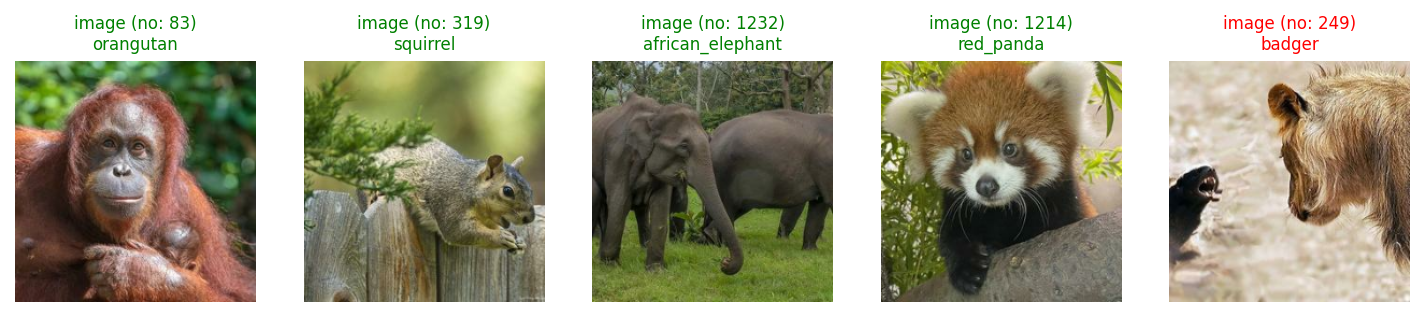

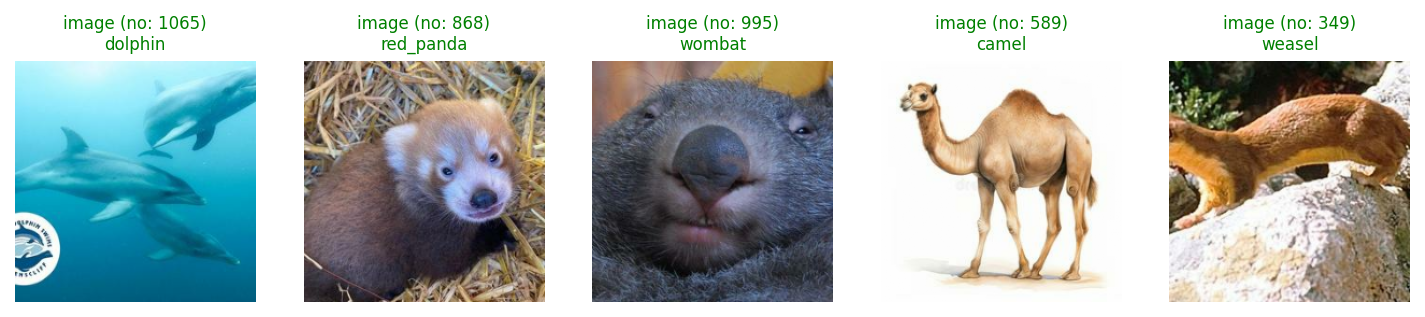

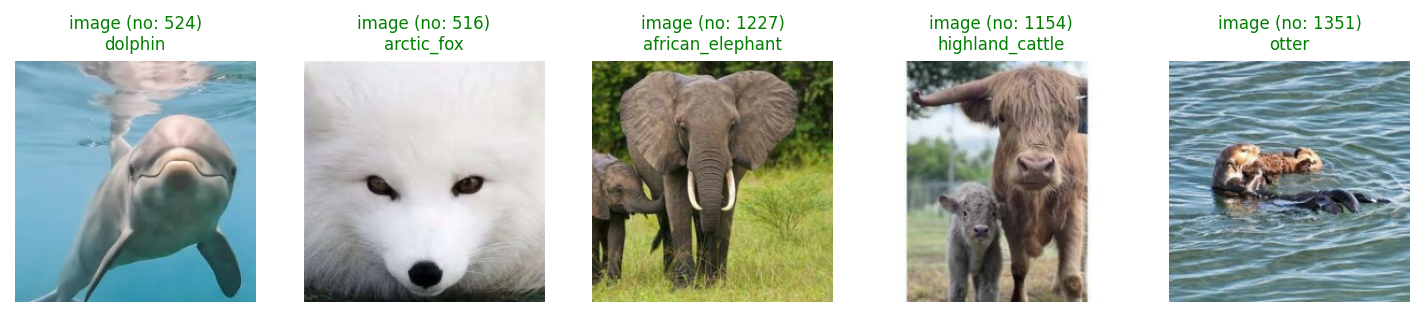

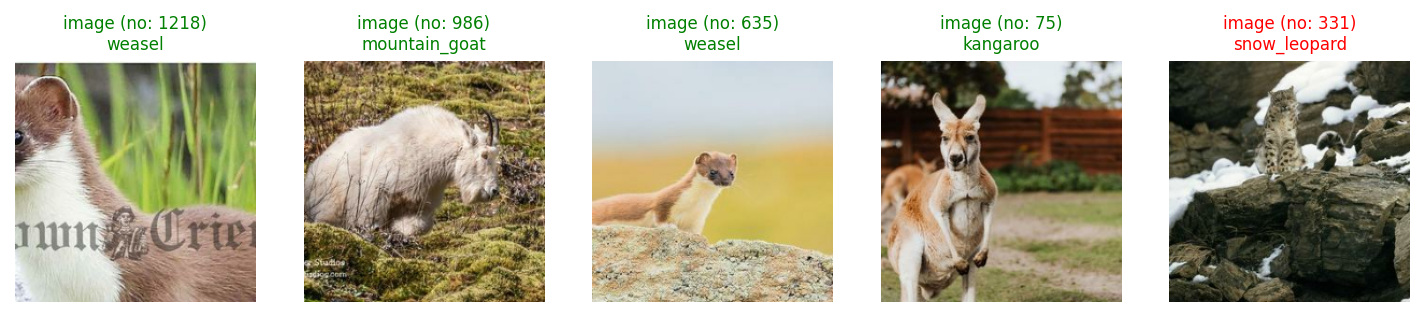

In [24]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 140)
random_test_sample_with_prediction(SEED = 20)
random_test_sample_with_prediction(SEED = 30)
random_test_sample_with_prediction(SEED = 5)